# Longitudinal QuasiCopula GWAS

Here we adopt the variance component model framework

$$\mathbf{\Gamma}_i(\mathbf{\theta}) = \sum_{k=1}^m \theta_k\mathbf{V}_{ik}, \quad \theta_k \ge 0$$

In [1]:
using Revise
using DataFrames, Random, GLM, QuasiCopula
using ForwardDiff, Test, LinearAlgebra
using LinearAlgebra: BlasReal, copytri!
using ToeplitzMatrices
using BenchmarkTools
using SnpArrays
using MendelPlots
using Statistics
using StatsBase

# using MendelPlots
ENV["COLUMNS"] = 240

BLAS.set_num_threads(1)
Threads.nthreads()

# simulate PLINK data where each SNP has at least min_ma copies of the alt allele
function simulate_random_snparray(s::Union{String, UndefInitializer}, n::Int64,
        p::Int64, mafs::Vector{Float64}; min_ma::Int = 1)
    all(0.0 .<= mafs .<= 0.5) || throw(ArgumentError("vector of minor allele frequencies must be in (0, 0.5)"))
#     any(mafs .<= 0.0005) && @warn("Provided minor allele frequencies contain entries smaller than 0.0005, simulation may take long if sample size is small and min_ma = $min_ma is large")

    #first simulate a random {0, 1, 2} matrix with each SNP drawn from Binomial(2, r[i])
    A1 = BitArray(undef, n, p) 
    A2 = BitArray(undef, n, p) 
    for j in 1:p
        minor_alleles = 0
        maf = mafs[j]
        while minor_alleles <= min_ma
            for i in 1:n
                A1[i, j] = rand(Bernoulli(maf))
                A2[i, j] = rand(Bernoulli(maf))
            end
            minor_alleles = sum(view(A1, :, j)) + sum(view(A2, :, j))
        end
    end

    #fill the SnpArray with the corresponding x_tmp entry
    return _make_snparray(s, A1, A2)
end


# function simulate_random_snparray(s::Union{String, UndefInitializer}, n::Int64,
#     p::Int64; mafs::Vector{Float64}=zeros(Float64, p), min_ma::Int = 5)

#     #first simulate a random {0, 1, 2} matrix with each SNP drawn from Binomial(2, r[i])
#     A1 = BitArray(undef, n, p) 
#     A2 = BitArray(undef, n, p) 
#     for j in 1:p
#         minor_alleles = 0
#         maf = 0
#         while minor_alleles <= min_ma
#             maf = 0.5rand()
#             for i in 1:n
#                 A1[i, j] = rand(Bernoulli(maf))
#                 A2[i, j] = rand(Bernoulli(maf))
#             end
#             minor_alleles = sum(view(A1, :, j)) + sum(view(A2, :, j))
#         end
#         mafs[j] = maf
#     end

#     #fill the SnpArray with the corresponding x_tmp entry
#     return _make_snparray(s, A1, A2)
# end

function _make_snparray(s::Union{String, UndefInitializer}, A1::BitArray, A2::BitArray)
    n, p = size(A1)
    x = SnpArray(s, n, p)
    for i in 1:(n*p)
        c = A1[i] + A2[i]
        if c == 0
            x[i] = 0x00
        elseif c == 1
            x[i] = 0x02
        elseif c == 2
            x[i] = 0x03
        else
            throw(MissingException("matrix shouldn't have missing values!"))
        end
    end
    return x
end

[ Info: Precompiling QuasiCopula [c47b6ae2-b804-4668-9957-eb588c99ffbc]


_make_snparray (generic function with 1 method)

## Simulate data

In [29]:
function simulate_VC_longitudinal(;
    n = 1000, # sample size
    d_min = 1, # min number of observations per sample
    d_max = 5, # max number of observations per sample
    p = 3, # number of nongenetic covariates, including intercept
    m = 1, # number of variance components
    q = 1000, # number of SNPs
    k = 10, # number of causal SNPs
    maf = 0.5rand(),
    causal_snp_β = 0.5rand(),
    seed = 2022,
    y_distribution = Bernoulli,
    T = Float64,
    )
    Random.seed!(seed)
    m == 1 || m == 2 || error("m (number of VC) must be 1 or 2")
    
    # non-genetic effect sizes
    Random.seed!(seed)
#     βtrue = [1.0; rand(-0.05:0.1:0.05, p-1)]
    βtrue = [1.0; rand(-0.5:1:0.5, p-1)]
#     βtrue = [1.0; rand(-5:10:5, p-1) .* rand(Uniform(0, 5), p-1)]
    dist = y_distribution()
    link = y_distribution == NegativeBinomial ? LogLink() : canonicallink(dist)
    Dist = typeof(dist)
    Link = typeof(link)

    # variance components
    θtrue = fill(0.1, m)

    # simulate (nongenetic) design matrices
    Random.seed!(seed)
    X_full = Matrix{Float64}[]
    for i in 1:n
        nobs = rand(d_min:d_max) # number of obs for this sample
        push!(X_full, hcat(ones(nobs), randn(nobs, p - 1)))
    end
    
    # simulate causal alleles
    Random.seed!(seed)
    γtrue = zeros(q)
    γtrue[1:k] .= causal_snp_β
    shuffle!(γtrue)
    
    # set minor allele freq
    mafs = fill(maf, q)
    
    # simulate random SnpArray with q SNPs with prespecified maf
    Random.seed!(seed)
    G = simulate_random_snparray(undef, n, q, mafs)
    Gfloat = convert(Matrix{T}, G, center=true, scale=false)
    
    # effect of causal alleles
    η_G = Gfloat * γtrue

    # simulate phenotypes
    if y_distribution == Normal
        τtrue = 0.01
        σ2 = inv(τtrue)
        σ = sqrt(σ2)
        obs = Vector{GaussianCopulaVCObs{T}}(undef, n)
        for i in 1:n
            # data matrix
            X = X_full[i]
            η = X * βtrue
            η .+= η_G[i] # add genetic effects
            μ = GLM.linkinv.(link, η)
            vecd = Vector{ContinuousUnivariateDistribution}(undef, size(X, 1))
            # VC matrices
#             V1 = SymmetricToeplitz(0.5.^(0:(size(X, 1)-1))) |> Matrix
            V1 = ones(size(X, 1), size(X, 1))
            V2 = Matrix(I, size(X, 1), size(X, 1))
            Γ = m == 1 ? θtrue[1] * V1 : θtrue[1] * V1 + θtrue[2] * V2
#             Γ = cov2cor(Γ, diag(Γ))
            for i in 1:size(X, 1)
                vecd[i] = y_distribution(μ[i], σ)
            end
            nonmixed_multivariate_dist = NonMixedMultivariateDistribution(vecd, Γ)
            # simuate single vector y
            y = Vector{T}(undef, size(X, 1))
            res = Vector{T}(undef, size(X, 1))
            rand(nonmixed_multivariate_dist, y, res)
            V = m == 1 ? [V1] : [V1, V2]
            obs[i] = GaussianCopulaVCObs(y, X, V)
        end
        qc_model = GaussianCopulaVCModel(obs)
    elseif y_distribution == NegativeBinomial
        rtrue = 1.0
        obs = Vector{NBCopulaVCObs{T, Dist, Link}}(undef, n)
        for i in 1:n
            # data matrix
            X = X_full[i]
            η = X * βtrue
            η .+= η_G[i] # add genetic effects
            μ = GLM.linkinv.(link, η)
            p = rtrue ./ (μ .+ rtrue)
            vecd = [NegativeBinomial(rtrue, p[i]) for i in 1:size(X, 1)]
            # VC matrices
            V1 = ones(size(X, 1), size(X, 1))
            V2 = Matrix(I, size(X, 1), size(X, 1))
            Γ = m == 1 ? θtrue[1] * V1 : θtrue[1] * V1 + θtrue[2] * V2
            nonmixed_multivariate_dist = NonMixedMultivariateDistribution(vecd, Γ)
            # simuate single vector y
            y = Vector{Float64}(undef, size(X, 1))
            res = Vector{Float64}(undef, size(X, 1))
            rand(nonmixed_multivariate_dist, y, res)
            V = m == 1 ? [V1] : [V1, V2]
            obs[i] = NBCopulaVCObs(y, X, V, dist, link)
        end
        qc_model = NBCopulaVCModel(obs)
    else # Bernoulli or Poisson
        obs = Vector{GLMCopulaVCObs{T, Dist, Link}}(undef, n)
        for i in 1:n
            # data matrix
            X = X_full[i]
            η = X * βtrue
            η .+= η_G[i] # add genetic effects
            μ = GLM.linkinv.(link, η)
            # VC matrices
            V1 = ones(size(X, 1), size(X, 1))
            V2 = Matrix(I, size(X, 1), size(X, 1))
            Γ = m == 1 ? θtrue[1] * V1 : θtrue[1] * V1 + θtrue[2] * V2
            vecd = Vector{DiscreteUnivariateDistribution}(undef, size(X, 1))
            for i in 1:size(X, 1)
                vecd[i] = y_distribution(μ[i])
            end
            nonmixed_multivariate_dist = NonMixedMultivariateDistribution(vecd, Γ)
            # simuate single vector y
            y = Vector{T}(undef, size(X, 1))
            res = Vector{T}(undef, size(X, 1))
            rand(nonmixed_multivariate_dist, y, res)
            V = m == 1 ? [V1] : [V1, V2]
            obs[i] = GLMCopulaVCObs(y, X, V, dist, link)
        end
        qc_model = GLMCopulaVCModel(obs)
    end
    return qc_model, G, βtrue, θtrue, γtrue
end

k = 0 # number of causal SNPs
maf = 0.3

qc_model, G, βtrue, θtrue, γtrue = simulate_VC_longitudinal(
    n = 5000, # sample size
    d_min = 1, # min number of observations per sample
    d_max = 5, # max number of observations per sample
    p = 3, # number of fixed effects, including intercept
    m = 1, # number of variance components
    q = 1000, # number of SNPs
    k = k, # number of causal SNPs
    seed = 2022,
    y_distribution = Normal,
    T = Float64,
    maf = maf,
    causal_snp_β = 0.2
)

@show qc_model;

qc_model = Quasi-Copula Variance Component Model
  * base distribution: Normal
  * link function: IdentityLink
  * number of clusters: 5000
  * cluster size min, max: 1, 5
  * number of variance components: 1
  * number of fixed effects: 3



## Fit Null model

In [30]:
@time optm = QuasiCopula.fit!(qc_model,
    Ipopt.IpoptSolver(
        print_level = 5, 
        tol = 10^-6, 
        max_iter = 1000,
        accept_after_max_steps = 50,
        warm_start_init_point="yes", 
        limited_memory_max_history = 6, # default value
        hessian_approximation = "limited-memory",
#         derivative_test="first-order"
    )
);

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        5
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [31]:
@show βtrue
@show qc_model.β
@show qc_model.∇β

@show θtrue
@show qc_model.θ
@show qc_model.∇θ;

@show qc_model.τ
@show qc_model.∇τ;

βtrue = [1.0, -0.5, 0.5]
qc_model.β = [0.9740664566496626, -0.5449071869185201, 0.45079600371622724]
qc_model.∇β = [3.788321878417378e-10, 7.961074507956134e-11, -4.21654433591101e-10]
θtrue = [0.1]
qc_model.θ = [0.11041961926219224]
qc_model.∇θ = [-1.1944918942852212e-9]
qc_model.τ = [0.009884835863015258]
qc_model.∇τ = [-3.2675769290335666e-7]


In [32]:
qc_model.data[1].X

1×3 Matrix{Float64}:
 1.0  -1.1156  -0.715519

In [34]:
qc_model.data[1].V

1-element Vector{Matrix{Float64}}:
 [1.0;;]

## Score tests

In [40]:
# gaussian
@time pvals = QuasiCopula.GWASCopulaVCModel(qc_model, G)

Wtime = 25.665537633795466
Qtime = 4.727058788015889
Rtime = 0.945388144029517
 33.959180 seconds (480.83 M allocations: 34.457 GiB, 7.08% gc time, 0.40% compilation time)


1000-element Vector{Float64}:
 0.08329062584358206
 0.7700725302567052
 0.2576748362251435
 0.6802117650448768
 0.6903176994917785
 0.525596451398987
 0.9935299648950817
 0.2822908656105898
 0.4424927674145147
 0.5570506584245316
 0.9323801149311963
 0.6903942926108345
 0.8374058074306575
 ⋮
 0.8223414861354496
 0.564281131097752
 0.03550791759989719
 0.5515555848692923
 0.9939641515681462
 0.899742835959601
 0.897947157868592
 0.2644055660933173
 0.6128016024352396
 0.6624563925430034
 0.16822842519935427
 0.509327856845314

In [ ]:
0.0832425991474118
 0.7700681711407448
 0.25746374765754554
 0.6802115272713305
 0.6902338186323869
 0.5255869646638811
 0.9935281342901139
 0.28228009777617696
 0.4424423614744735
 0.557050776592052
 0.9323778725198326
 0.6903932132736122
 0.8373829475165003

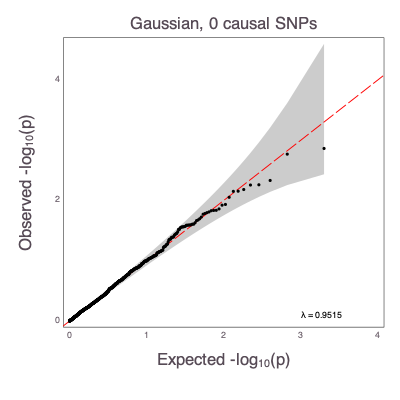

In [41]:
# gaussian
qq(pvals, dpi=80, titles="Gautssian, $k causal SNPs")
display("image/png", read("qqplot.png"))

In [16]:
# neg bin
@time pvals = QuasiCopula.GWASCopulaVCModel(qc_model, G)

LoadError: InterruptException:

In [9]:
# bernoulli
@time pvals = QuasiCopula.GWASCopulaVCModel(qc_model, G)

Wtime = 31.50527806184223
Qtime = 5.151968675013326
Rtime = 1.302317392954952
 41.380924 seconds (513.96 M allocations: 36.195 GiB, 10.50% gc time, 2.21% compilation time)


1000-element Vector{Float64}:
 0.042233730380429796
 0.6260522783632397
 0.41752038726670065
 0.9237248799378781
 0.8991389365186692
 0.2105705884445346
 0.8763265947972066
 0.6444418776606736
 0.2124630697966753
 0.8253806794098835
 0.20142208400693984
 0.769411155952143
 0.896775075246224
 ⋮
 0.16166717166138278
 0.582099581199708
 0.16789123818202537
 0.8685145268128954
 0.8818345013347846
 0.8877462105508966
 0.4233582525136207
 0.6040949737838887
 0.09258604112184797
 0.9816270415583414
 0.17225901871224494
 0.8200253670142064

In [18]:
# gaussian
@time pvals = QuasiCopula.GWASCopulaVCModel(qc_model, G)

Wtime = 25.482530241013084
Qtime = 4.937502905986128
Rtime = 0.9205016850492228
 34.085986 seconds (480.58 M allocations: 34.427 GiB, 10.53% gc time, 0.36% compilation time)


1000-element Vector{Float64}:
 0.07740282322396841
 0.7665680179045387
 0.2570013153670397
 0.6797872278930456
 0.6839686116790977
 0.5245895626850355
 0.9934647055831579
 0.2710066513077909
 0.44028856134062244
 0.5509263033561254
 0.9316785694738963
 0.6891818305885606
 0.8363374706503802
 ⋮
 0.8205692472527488
 0.5570666211288706
 0.03526634908272062
 0.550831271750818
 0.9939212825903295
 0.8974286393083974
 0.8966518949482997
 0.2574634409518363
 0.610835091302649
 0.6591947223414515
 0.16187001496851394
 0.5003587036430847

In [20]:
# gaussian
@time pvals = QuasiCopula.GWASCopulaVCModel(qc_model, G)

qc_model.Hβ = [-162.2664802189268 -0.05457964332337806 0.24755860993878168; -0.011624687721643408 -153.0283600268151 0.05491723059919537; 0.474672513984509 -0.03237175461783571 -152.506905700754]
H = [-14973.697613987135 -5.355337239909119 25.11638520961124; -5.355337239909119 -15105.915378645206 5.803343030303507; 25.116385209611227 5.803343030303507 -15062.343325942618]


LoadError: UndefVarError: fdsa not defined

In [65]:
# gaussian
@time pvals = QuasiCopula.GWASCopulaVCModel(qc_model, G)

Wtime = 34.04018521826432
Qtime = 4.196841406071264
Rtime = 0.7939399660465563
 43.212379 seconds (544.43 M allocations: 49.912 GiB, 8.21% gc time, 1.56% compilation time)


1000-element Vector{Float64}:
 0.17118119984509148
 0.4339647970347588
 0.3511543977408576
 0.83935765669281
 0.6801260333238445
 0.5906753323990214
 0.7898223386146164
 0.7044653610760244
 0.6939683818527844
 0.06631628212221746
 0.667797742500777
 0.6616142426803451
 0.5315054826335621
 ⋮
 0.600429046857131
 0.513560958015882
 0.6059096735267697
 0.810353383710075
 0.20910818760279587
 0.7651536404441015
 0.8706328955705778
 0.20865343023055702
 0.9868628083270872
 0.0465943835442187
 0.9130557859999213
 0.6985693710457513

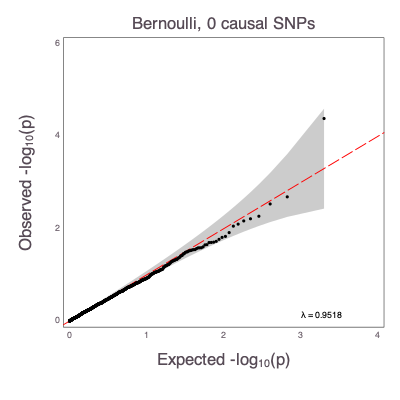

In [10]:
# Bernoulli
qq(pvals, dpi=80, titles="Bernoulli, $k causal SNPs")
display("image/png", read("qqplot.png"))

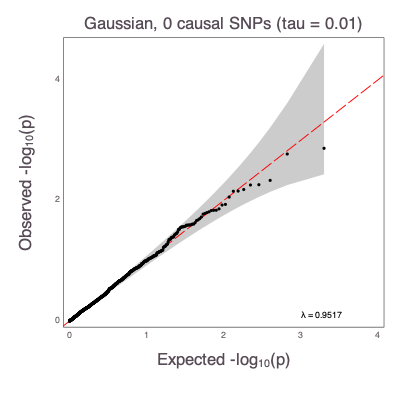

In [18]:
# gaussian
qq(pvals, dpi=80, titles="Gaussian, $k causal SNPs (tau = 0.01)")
display("image/png", read("qqplot.png"))

In [67]:
# autodiff neg bin
@time pvals = QuasiCopula.GWASCopulaVCModel_autodiff(qc_model, G)

 29.190420 seconds (14.63 M allocations: 823.277 MiB, 0.44% gc time, 13.56% compilation time)


1000-element Vector{Float64}:
 0.1712032643163831
 0.4334133249111317
 0.35114944179806296
 0.8392170202562473
 0.6800838302970833
 0.5905241941750995
 0.7897819517579051
 0.7044181665991562
 0.6939608329894125
 0.06605618077169823
 0.6678007788262487
 0.661625937999494
 0.5314803416379907
 ⋮
 0.6004117050212023
 0.5123331396297083
 0.6057252611373987
 0.8103209253112313
 0.2090841443035635
 0.7649546514896467
 0.8705980654600124
 0.20854588923599854
 0.986861622435853
 0.04642950931954789
 0.913028403166554
 0.6985400352512876

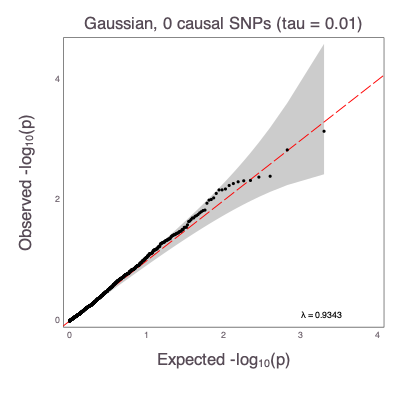

In [68]:
qq(pvals, dpi=80, titles="Gaussian, $k causal SNPs (tau = 0.01)")
display("image/png", read("qqplot.png"))

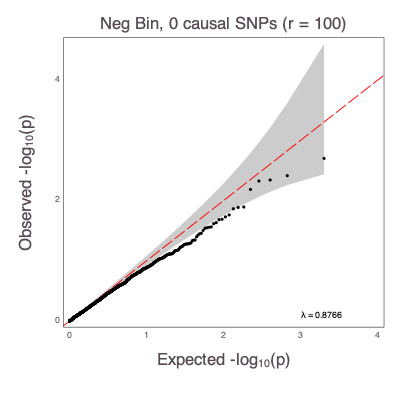

In [51]:
qq(pvals, dpi=80, titles="Neg Bin, $k causal SNPs (r = 100)")
display("image/png", read("qqplot.png"))

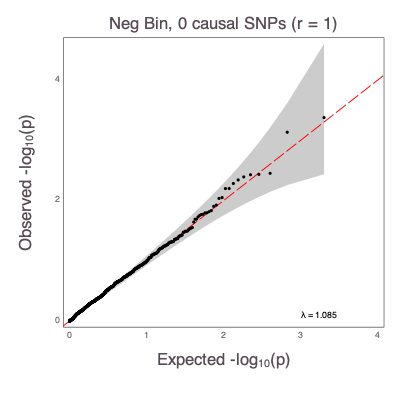

In [57]:
qq(pvals, dpi=80, titles="Neg Bin, $k causal SNPs (r = 1)")
display("image/png", read("qqplot.png"))

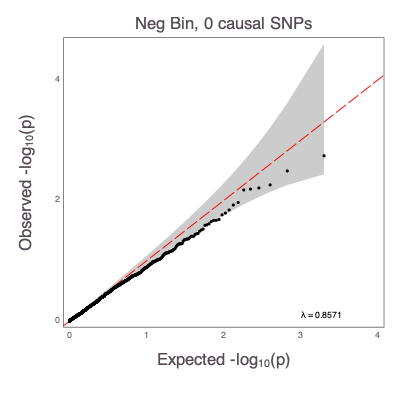

In [21]:
qq(pvals, dpi=80, titles="Neg Bin, $k causal SNPs")
display("image/png", read("qqplot.png"))

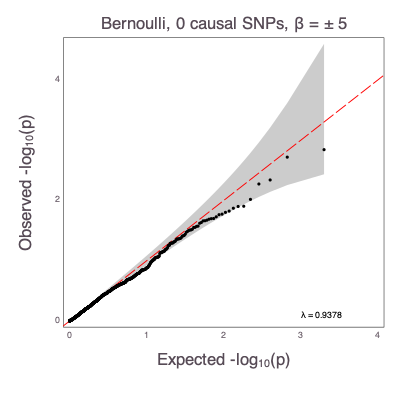

In [44]:
qq(pvals, dpi=80, titles="Bernoulli, $k causal SNPs, β = ± 5")
display("image/png", read("qqplot.png"))

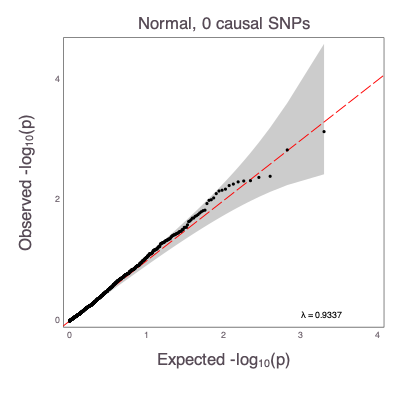

In [63]:
qq(pvals, dpi=80, titles="Normal, $k causal SNPs")
display("image/png", read("qqplot.png"))

In [33]:
# autodiff neg bin
@time pvals = QuasiCopula.GWASCopulaVCModel_autodiff(qc_model, G)

size(Hfull, 1) = 7
rank(Hfull) = 6
rank(Hfull[1:end - 1, 1:end - 1]) = 5


LoadError: SingularException(4)

In [66]:
# autodiff gaussian
@time pvals = QuasiCopula.GWASCopulaVCModel_autodiff(qc_model, G)

 27.280767 seconds (13.59 M allocations: 755.576 MiB, 0.50% gc time, 12.51% compilation time)


1000-element Vector{Float64}:
 0.17120321640591382
 0.43341328809194507
 0.3511494954678522
 0.8392169501079304
 0.680083815495358
 0.5905240715882919
 0.7897820104533161
 0.7044182319736411
 0.6939609281615305
 0.0660561508871385
 0.6678007826563708
 0.6616258540458355
 0.5314803448251156
 ⋮
 0.6004117509675786
 0.512333175931102
 0.605725378269697
 0.8103209063230566
 0.2090841576111163
 0.764954764743121
 0.8705980333029041
 0.20854589224810335
 0.9868616519224109
 0.046429501014578316
 0.9130283650183032
 0.6985398882027449

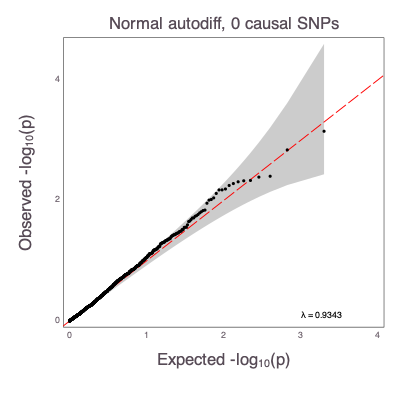

In [67]:
# check Gaussian using autodiff: it includes tau in grad/Hess -> not very different to excluding tau
qq(pvals, dpi=80, titles="Normal autodiff, $k causal SNPs")
display("image/png", read("qqplot.png"))

## Correctness: compare to autodiff

In [5]:
# autodiff
@time pvals = QuasiCopula.GWASCopulaVCModel_autodiff(qc_model, G)

R = 1.2944122036132124
Q = 334.07504773219074
W = [-4.1101463769673385, -0.38710090503513683, 10.128626121553435, 28.08718187630317, -3.9828060609992217]


LoadError: UndefVarError: fdsa not defined

In [9]:
# mathematical
@time pvals = QuasiCopula.GWASCopulaVCModel(qc_model, G)

R = 1.2944122028286387
Q = 334.07504773003683
W = [-4.110146378536879, -0.3871009113902798, 10.128626122634698, 28.087181876303358, -3.9828060609994456]


LoadError: UndefVarError: fdsa not defined